# Assigning papers
In this notebook, I solve the linear assignment problem, to give each group of students a paper according to the global preferences.

In [1]:
%pylab inline
figsize(8,5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as spi

## Importing answers from the google form

In [3]:
data = pd.read_csv("rankings.csv")

In [4]:
data.head()

,Timestamp,first and last name of group member 1,first and last name of group member 2,"first and last name of group member 3 (if not filled, must have been discussed with us first)","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 1: Bhattacharya et al., JASA'15]","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 2]","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 3]","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 4]","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 5]","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 6]",...,"Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 21]","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 22]","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 23]","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 24]","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 25]","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 26]","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 27]","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 28]","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 29]","Each row is a paper, each column is a preference order. Please assign a unique preference to all papers. [Row 30: Wang, BA'17]"
0,2017/11/27 8:53:10 AM GMT+1,Yassine Benazzou,Marion Karakouzian,Charles Dognin,Column 18,Column 17,Column 10,Column 11,Column 9,Column 1: Top preference,...,Column 28,Column 16,Column 8,Column 6,Column 12,Column 4,Column 26,Column 30: Lowest preference,Column 7,Column 13
1,2017/11/27 6:43:34 PM GMT+1,Nguyen Victor,Perrin Julien,Loiseau Nicolas,Column 6,Column 7,Column 5,Column 8,Column 9,Column 4,...,Column 22,Column 23,Column 24,Column 3,Column 25,Column 26,Column 27,Column 28,Column 29,Column 30: Lowest preference
2,2017/11/27 10:35:01 PM GMT+1,Nicolas Schreuder,Sholom Schechtman,Amélie Segard,Column 5,Column 16,Column 20,Column 13,Column 12,Column 1: Top preference,...,Column 23,Column 29,Column 11,Column 15,Column 4,Column 9,Column 7,Column 8,Column 10,Column 28
3,2017/11/28 2:30:37 PM GMT+1,Johanna Lalou,Franz Antoine,Carles Jean-Christophe,Column 20,Column 15,Column 17,Column 3,Column 10,Column 1: Top preference,...,Column 16,Column 27,Column 14,Column 7,Column 22,Column 12,Column 8,Column 28,Column 29,Column 30: Lowest preference
4,2017/11/28 4:38:08 PM GMT+1,LEVY Thomas,LE MEUR Vincent,WATRIGANT Timothée,Column 14,Column 15,Column 16,Column 17,Column 5,Column 2,...,Column 28,Column 29,Column 26,Column 1: Top preference,Column 4,Column 23,Column 24,Column 10,Column 3,Column 25


In [5]:
r = data.values[:,1:].copy()
groups = []
nRaw, pRaw = r.shape
print("n, p =", nRaw, pRaw) # Check n is equal to number of answers on Google Form: yes
for row in r:
    groups.append([name for name in row[:3]])
    for i in range(3,pRaw):
        pref = row[i].split(' ')[1]
        row[i] = int(pref) if pref[-1] != ':' else int(pref[:-1]) 

r = r[:, 3:] # now r should contain only integers indicating the preferences
nBeforeLatecomers, p = r.shape

n, p = 29 33


In [6]:
# Manually adding latecomers, grrr.
groups.append(["Ahmed Ben Salem", "Anouar Barchid"])
pref = 4*np.ones(p)
pref[8] = 1
pref[5] = 2
pref[10]= 3
r = np.concatenate((r, pref.reshape((1,p))))
n, p = r.shape
print("n, p= ", n, p)

n, p=  30 30


In [7]:
# some sanity checks 
print(r[:3])
print(groups[:3])
print(groups[-4:])

[[18 17 10 11 9 1 5 19 29 2 22 15 25 3 14 27 20 21 24 23 28 16 8 6 12 4 26
  30 7 13]
 [6 7 5 8 9 4 2 10 11 1 12 13 14 15 16 17 18 19 20 21 22 23 24 3 25 26 27
  28 29 30]
 [5 16 20 13 12 1 3 14 6 21 24 25 26 27 30 17 18 19 22 2 23 29 11 15 4 9 7
  8 10 28]]
[['Yassine Benazzou', 'Marion Karakouzian', 'Charles Dognin'], ['Nguyen Victor', 'Perrin Julien', 'Loiseau Nicolas'], ['Nicolas Schreuder', 'Sholom Schechtman', 'Amélie Segard']]
[['Yoan Russac', 'Marc Etheve', 'Clément Giron'], ['Samuel Ritchie', 'Robin Beaudet', 'Jean-Baptiste Remy'], ['Mathis Linger', 'Nicolas Huille', nan], ['Ahmed Ben Salem', 'Anouar Barchid']]


## Solving the linear assignment problem

Let $x_{ij}=1$ if group $i$ is assigned paper $j$, and $0$ otherwise. We have imposed a maximum of 2 groups per paper
$$ 
\sum_i x_{ij}\leq 2, \forall j
$$
and each group must have a paper
$$
\sum_j x_{ij} = 1, \forall i.
$$
We assume that the cost of assigning paper $j$ to group $i$ is proportional to the ranking $r_{ij}$ that group $i$ assigned to paper $j$. So we need to solve
$$
\min \sum r_{ij}x_{ij}
$$
subject to both constraints, and $x_i\geq 0$.

In [8]:
# We need to write the constraints in vector form, with x = (x_11,...,x_1P,x_21,...)
c = r.flatten()
A1 = np.concatenate([np.eye(p) for _ in range(n)], 1)
A2 = np.kron(np.eye(n), np.ones((1,p))) 

# sanity checks
print("c=", c[:10], "...")
print(A1.shape)
print(np.matrix(A1))
print(A2.shape)
print(np.matrix(A2))

c= [18 17 10 11 9 1 5 19 29 2] ...
(30, 900)
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
(30, 900)
[[ 1.  1.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  1.  1.]]


In [9]:
c = r.flatten()
res = spi.linprog(c, A_ub=A1, b_ub=2*np.ones((p,1)), A_eq=A2, b_eq=np.ones((n,1)), method="simplex")

47.0 Optimization terminated successfully.
On average, each group got its 1.56666666667 wish


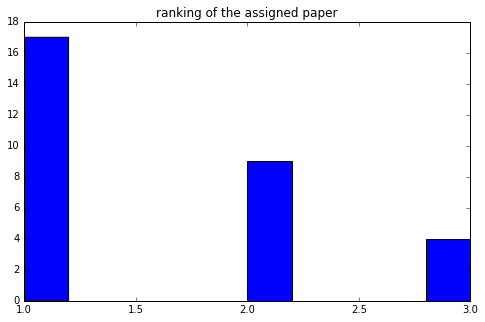

In [10]:
print(res.fun, res.message)
print("On average, each group got its", res.fun/n, "wish")
prefs =  c[np.where(res.x)] #
plt.hist(prefs)
plt.title("ranking of the assigned paper")
plt.show()

So about half of you got their first wish. And, worst case, you got your third wish.

In [11]:
import math # to detect nan's

# Print assignemnts, paper numbers refer to the pdf we sent to describe the project
x = np.reshape(res.x, ((n,p)))
with open('paperAssignment.txt','w') as f:
    for i in range(len(x)):
        for person in groups[i]:
            try:
                math.isnan(person)
            except:
                f.write(person+", ")
        f.write("Paper: "+str(1+np.where(x[i])[0][0])) # add one to convert 0-based 
                                                       # indexing to bibtex numbering
        f.write("\n")

In [12]:
# Sanity check
with open('paperAssignment.txt','r') as f:
    contents = f.read()
    print(contents)

Yassine Benazzou, Marion Karakouzian, Charles Dognin, Paper: 6
Nguyen Victor, Perrin Julien, Loiseau Nicolas, Paper: 10
Nicolas Schreuder, Sholom Schechtman, Amélie Segard, Paper: 20
Johanna Lalou, Franz Antoine, Carles Jean-Christophe, Paper: 4
LEVY Thomas, LE MEUR Vincent, WATRIGANT Timothée, Paper: 24
Hicham El Boukkouri, Michael Sok, Enguerand Acquarone, Paper: 10
Jessica Matheron, Selim Dekali, Romuald Menuet, Paper: 8
Léa BRESSON, Kolia IAKOVLEV, Elvire ROBLINd, Paper: 14
Arthur Imbert, Gilles Cornec, Loïc Macherel, Paper: 28
Albane Miron de l'Espinay, Erwan Bourceret, Matthieu Doutreligne, Paper: 14
Elie Azeraf, Amine Hammami, Benjamin , Paper: 7
Quan SUN, Wensi DING, Shasha CUI, Paper: 3
Xingyuan XUE, Yicheng ZHANG, Geremie DJOHOSSOU, Paper: 27
Mehdi Abbana Bennani, Sébastien Coube, Yannick Terme, Paper: 15
Dimitri Bouche, Rémi de Torres, Cyril Verluise, Paper: 3
Bruno ABILOU, Fatoumata DANSOKHO , Karim BENKIRANE , Paper: 7
Sameh Rahmouni, Caroline Boucly, Geoffroy Ransac, Pape